In [3]:
import os 
import numpy as np
import cv2

import matplotlib.pyplot as plt
import matplotlib.image as  mping
%matplotlib inline

from PIL import Image
from IPython.display import display

import torch 
import torch.nn as nn

from torch.utils.data import DataLoader

import torch.nn.functional as F
from torchvision import datasets, transforms , models
from torch.optim.lr_scheduler import StepLR
from torchsummary import summary
from tqdm import tqdm

In [4]:
data_path = "chest_xray"

### Data Exploration

In [5]:
class_name = ['NORMAL','PNEUMONIA']

def get_list_files(dirName):
    files_list = os.listdir(dirName)
    return files_list

files_list_normal_train = get_list_files(data_path+'/train/'+class_name[0])
files_list_pneu_train = get_list_files(data_path+'/train/'+class_name[1])


files_list_normal_test = get_list_files(data_path+'/test/'+class_name[0])
files_list_pneu_test = get_list_files(data_path+'/test/'+class_name[1])

print(len(files_list_normal_train))
print(len(files_list_pneu_train))

50
50


View sample images 

(1631, 1928)


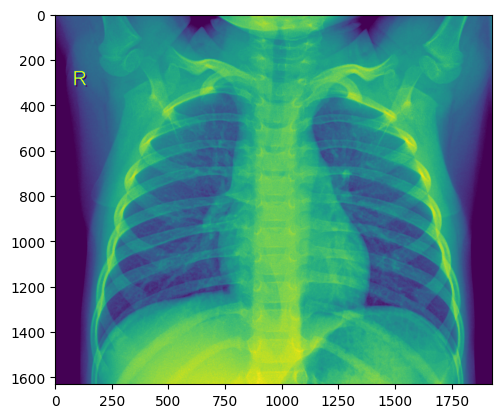

In [6]:
rand_img_no = np.random.randint(0,len(files_list_normal_train))
img = data_path + '/train/NORMAL/'+ files_list_normal_train[rand_img_no]
print(plt.imread(img).shape)

img = mping.imread(img)
imgplot = plt.imshow(img)
plt.show()

(1016, 1320)


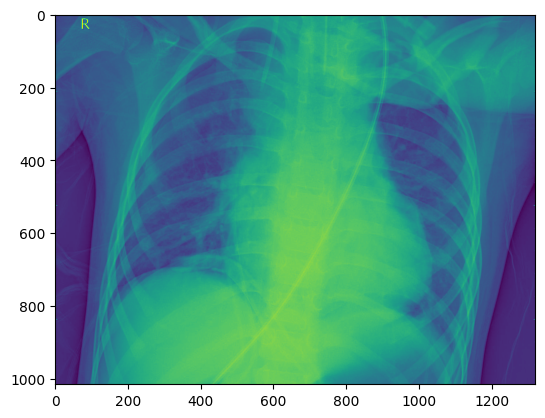

In [7]:
rand_img_no = np.random.randint(0,len(files_list_pneu_train))
img = data_path + '/train/PNEUMONIA/'+ files_list_pneu_train[rand_img_no]
print(plt.imread(img).shape)

img = mping.imread(img)
imgplot = plt.imshow(img)
plt.show()

### Data Loader

In [8]:
train_tranform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                        [0.229, 0.224, 0.225])])

test_tranform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                        [0.229, 0.224, 0.225])])

train_data = datasets.ImageFolder(os.path.join(data_path,'train'),transform=train_tranform)
test_data = datasets.ImageFolder(os.path.join(data_path,'test'),transform=test_tranform)

train_loader = DataLoader(train_data,batch_size=16, shuffle=True,pin_memory=True)
test_loader = DataLoader(test_data, batch_size=1, shuffle=False, pin_memory=True)

class_names = train_data.classes

print(class_names)
print(len(train_data))
print(len(test_data))

['NORMAL', 'PNEUMONIA']
100
20


### Define the Model

In [9]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        #Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=3,out_channels=8,
                     kernel_size=(3,3),padding=0,bias= False),
            nn.ReLU()
        )
        self.pool11= nn.MaxPool2d(2,2)
        # CONVOLUTION BLOCK
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, 
                     kernel_size=(3,3),padding=0,bias=False),
            nn.ReLU()
        )
        # Transition Block
        self.pool22 = nn.MaxPool2d(2,2)
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=16,out_channels=10,kernel_size=(1,1),
                     padding=0, bias= False),
            nn.ReLU()
        )
        self.pool33 = nn.MaxPool2d(2, 2)
         # CONVOLUTION BLOCK
        self.convblock4 = nn.Sequential(
             nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
             nn.ReLU(),
            
             )
        self.convblock5 = nn.Sequential(
         nn.Conv2d(in_channels=10, out_channels=32, kernel_size=(1, 1), padding=0, bias=False),
         #nn.BatchNorm2d(32),
         nn.ReLU(),
         )
        
        self.convblock6 = nn.Sequential(
         nn.Conv2d(in_channels=32, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
         nn.ReLU(),
         #nn.BatchNorm2d(10),
         )
        
        self.convblock7 = nn.Sequential(
         nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
         nn.ReLU(),
         #nn.BatchNorm2d(10)
         )
        
        self.convblock8 = nn.Sequential(
         nn.Conv2d(in_channels=10, out_channels=32, kernel_size=(1, 1), padding=0, bias=False),
         #nn.BatchNorm2d(32),
         nn.ReLU()
         )
            
        self.convblock9 = nn.Sequential(
         nn.Conv2d(in_channels=32, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
         nn.ReLU(),
         #nn.BatchNorm2d(10),
         )
        
        self.convblock10 = nn.Sequential(
         nn.Conv2d(in_channels=10, out_channels=14, kernel_size=(3, 3), padding=0, bias=False),
         nn.ReLU(),
         #nn.BatchNorm2d(14),
         )
        self.convblock11 = nn.Sequential(
         nn.Conv2d(in_channels=14, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
             nn.ReLU()
         )
            
        # OUTPUT BLOCK
        self.gap = nn.Sequential(
         nn.AvgPool2d(kernel_size=4)
         )
        self.convblockout = nn.Sequential(
         nn.Conv2d(in_channels=16, out_channels=2, kernel_size=(4, 4), padding=0, bias=False),
         )
        
    def forward(self, x):
        x = self.convblock1(x)
        x = self.pool11(x)
        x = self.convblock2(x)
        x = self.pool22(x)
        x = self.convblock3(x)
        x = self.pool33(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.convblock8(x)
        x = self.convblock9(x)
        x = self.convblock10(x)
        x = self.convblock11(x)
        x = self.gap(x)
        x = self.convblockout(x)
        x = x.view(-1, 2)
        return F.log_softmax(x, dim=-1)


In [10]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print("Available processor {}".format(device))
model = Net().to(device)
summary(model, input_size=(3, 224, 224))

Available processor cpu
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 222, 222]             216
              ReLU-2          [-1, 8, 222, 222]               0
         MaxPool2d-3          [-1, 8, 111, 111]               0
            Conv2d-4         [-1, 16, 109, 109]           1,152
              ReLU-5         [-1, 16, 109, 109]               0
         MaxPool2d-6           [-1, 16, 54, 54]               0
            Conv2d-7           [-1, 10, 54, 54]             160
              ReLU-8           [-1, 10, 54, 54]               0
         MaxPool2d-9           [-1, 10, 27, 27]               0
           Conv2d-10           [-1, 10, 25, 25]             900
             ReLU-11           [-1, 10, 25, 25]               0
           Conv2d-12           [-1, 32, 25, 25]             320
             ReLU-13           [-1, 32, 25, 25]               0
           Conv

### The Training Process

In [17]:
train_losses = []
test_losses = []
train_acc = []
test_acc= []

def train(model, device, train_loader, optimizer, epoch):
    model.train()
    pbar = tqdm(train_loader)
    correct = 0
    processed = 0
    for batch_idx, (data, target) in enumerate(pbar):
        #get data
        data, target = data.to(device), target.to(device)
        
        #initialization of gradiient
        optimizer.zero_grad()
        
        y_pred = model(data)
        
        #calculate loss given the prediction
        loss= F.nll_loss(y_pred, target)
        train_losses.append(loss)
        
        #back prop
        loss.backward()
        optimizer.step()
        
        #get the index of the log-probability corresponding to the max value
        pred = y_pred.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        processed += len(data)
        
        pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
        train_acc.append(100*correct/processed)
        
def test(model,device, test_loader):
    model.eval()
    test_loss = 0
    correct =0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            
            
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    
    print('\nTest set: Average loss: {:.4f}, Accuracy= {}/{}({:.2f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))
    

In [18]:
model = Net().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=6, gamma=0.5)

EPOCHs = 15
for epoch in range(EPOCHs):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    scheduler.step()
    print('current Learning Rate: ', optimizer.state_dict()['param_groups'][0]['lr'])
    test(model, device, test_loader)

EPOCH: 0


Loss=0.693148672580719 Batch_id=6 Accuracy=47.00: 100%|██████████████████████████████████| 7/7 [00:05<00:00,  1.25it/s]


current Learning Rate:  0.01

Test set: Average loss: 0.6931, Accuracy= 9/20(45.00%)

EPOCH: 1


Loss=0.6931478977203369 Batch_id=6 Accuracy=47.00: 100%|█████████████████████████████████| 7/7 [00:05<00:00,  1.29it/s]


current Learning Rate:  0.01

Test set: Average loss: 0.6931, Accuracy= 9/20(45.00%)

EPOCH: 2


Loss=0.6931465268135071 Batch_id=6 Accuracy=47.00: 100%|█████████████████████████████████| 7/7 [00:05<00:00,  1.29it/s]


current Learning Rate:  0.01

Test set: Average loss: 0.6931, Accuracy= 9/20(45.00%)

EPOCH: 3


Loss=0.6931467652320862 Batch_id=6 Accuracy=47.00: 100%|█████████████████████████████████| 7/7 [00:05<00:00,  1.30it/s]


current Learning Rate:  0.01

Test set: Average loss: 0.6931, Accuracy= 9/20(45.00%)

EPOCH: 4


Loss=0.6931485533714294 Batch_id=6 Accuracy=47.00: 100%|█████████████████████████████████| 7/7 [00:05<00:00,  1.30it/s]


current Learning Rate:  0.01

Test set: Average loss: 0.6931, Accuracy= 9/20(45.00%)

EPOCH: 5


Loss=0.693148136138916 Batch_id=6 Accuracy=47.00: 100%|██████████████████████████████████| 7/7 [00:05<00:00,  1.29it/s]


current Learning Rate:  0.005

Test set: Average loss: 0.6931, Accuracy= 9/20(45.00%)

EPOCH: 6


Loss=0.6931471824645996 Batch_id=6 Accuracy=47.00: 100%|█████████████████████████████████| 7/7 [00:06<00:00,  1.07it/s]


current Learning Rate:  0.005

Test set: Average loss: 0.6931, Accuracy= 9/20(45.00%)

EPOCH: 7


Loss=0.6931480765342712 Batch_id=6 Accuracy=47.00: 100%|█████████████████████████████████| 7/7 [00:05<00:00,  1.22it/s]


current Learning Rate:  0.005

Test set: Average loss: 0.6931, Accuracy= 9/20(45.00%)

EPOCH: 8


Loss=0.6931466460227966 Batch_id=6 Accuracy=47.00: 100%|█████████████████████████████████| 7/7 [00:05<00:00,  1.22it/s]


current Learning Rate:  0.005

Test set: Average loss: 0.6931, Accuracy= 9/20(45.00%)

EPOCH: 9


Loss=0.6931465268135071 Batch_id=6 Accuracy=47.00: 100%|█████████████████████████████████| 7/7 [00:05<00:00,  1.28it/s]


current Learning Rate:  0.005

Test set: Average loss: 0.6931, Accuracy= 9/20(45.00%)

EPOCH: 10


Loss=0.6931463479995728 Batch_id=6 Accuracy=47.00: 100%|█████████████████████████████████| 7/7 [00:05<00:00,  1.33it/s]


current Learning Rate:  0.005

Test set: Average loss: 0.6931, Accuracy= 9/20(45.00%)

EPOCH: 11


Loss=0.693148136138916 Batch_id=6 Accuracy=47.00: 100%|██████████████████████████████████| 7/7 [00:05<00:00,  1.32it/s]


current Learning Rate:  0.0025

Test set: Average loss: 0.6931, Accuracy= 9/20(45.00%)

EPOCH: 12


Loss=0.6931469440460205 Batch_id=6 Accuracy=47.00: 100%|█████████████████████████████████| 7/7 [00:05<00:00,  1.33it/s]


current Learning Rate:  0.0025

Test set: Average loss: 0.6931, Accuracy= 9/20(45.00%)

EPOCH: 13


Loss=0.6931474208831787 Batch_id=6 Accuracy=47.00: 100%|█████████████████████████████████| 7/7 [00:05<00:00,  1.29it/s]


current Learning Rate:  0.0025

Test set: Average loss: 0.6931, Accuracy= 9/20(45.00%)

EPOCH: 14


Loss=0.6931463479995728 Batch_id=6 Accuracy=47.00: 100%|█████████████████████████████████| 7/7 [00:05<00:00,  1.33it/s]


current Learning Rate:  0.0025

Test set: Average loss: 0.6931, Accuracy= 9/20(45.00%)



Text(0.5, 1.0, 'Test Accuracy')

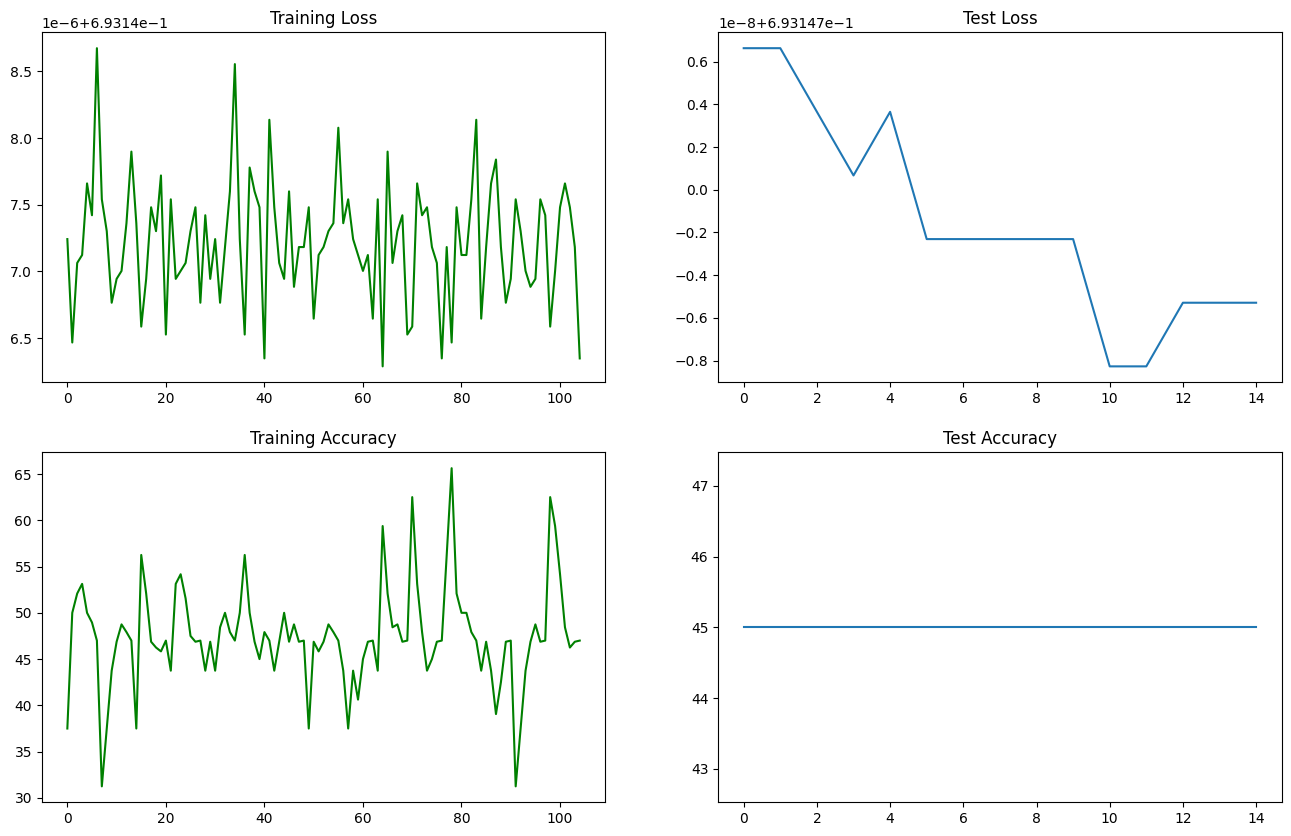

In [20]:
train_losses1 = [float(i.cpu().detach().numpy())for i in train_losses]
train_acc1 = [i for i in train_acc]
test_losses1 = [i for i in test_losses]
test_acc1 = [i for i in test_acc]

fig, axs = plt.subplots(2,2, figsize=(16,10))
axs[0,0].plot(train_losses1, color='green')
axs[0,0].set_title("Training Loss")
axs[1,0].plot(train_acc1, color='green')
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses1)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc1)
axs[1, 1].set_title("Test Accuracy")


### The Secode Variation of Model

augmentation code block

In [23]:
train_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ColorJitter(brightness=0.10, contrast=0.1,
    saturation=0.10, hue=0.1),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                        [0.229, 0.224, 0.225])

])

test_transform = transforms.Compose([
     transforms.Resize(224),
     transforms.CenterCrop(224),
     transforms.ToTensor(),
     transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

train_data = datasets.ImageFolder(os.path.join(data_path,'train'),transform=train_tranform)
test_data = datasets.ImageFolder(os.path.join(data_path,'test'),transform=test_tranform)

train_loader = DataLoader(train_data,batch_size=16, shuffle=True,pin_memory=True)
test_loader = DataLoader(test_data, batch_size=1, shuffle=False, pin_memory=True)

class_names = train_data.classes

print(class_names)
print(len(train_data))
print(len(test_data))

['NORMAL', 'PNEUMONIA']
100
20


In [22]:
class Nel(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8,
                     kernel_size=(3,3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(8)
        )
        self.pool11 = nn.MaxPool2d(2, 2)
        
        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
             nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3),
             padding=0, bias=False),
             nn.ReLU(),
             nn.BatchNorm2d(16)
         )
        
        self.pool22 = nn.MaxPool2d(2, 2)
        
        self.convblock3 = nn.Sequential(
             nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
             nn.ReLU(),
             nn.BatchNorm2d(10),
             )
        self.pool33 = nn.MaxPool2d(2, 2)
        
        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
             nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
             nn.ReLU(),
             nn.BatchNorm2d(10)
         )
        self.convblock5 = nn.Sequential(
             nn.Conv2d(in_channels=10, out_channels=32, kernel_size=(1, 1), padding=0, bias=False),
             nn.ReLU(),
             nn.BatchNorm2d(32),
             )
        self.convblock6 = nn.Sequential(
             nn.Conv2d(in_channels=32, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
             nn.ReLU(),
             nn.BatchNorm2d(10),
         )
        self.convblock7 = nn.Sequential(
             nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
             nn.ReLU(),
             nn.BatchNorm2d(10)
             )
        
        self.convblock8 = nn.Sequential(
             nn.Conv2d(in_channels=10, out_channels=32, kernel_size=(1, 1), padding=0, bias=False),
             nn.ReLU(),
             nn.BatchNorm2d(32)
             )
        self.convblock9 = nn.Sequential(
             nn.Conv2d(in_channels=32, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
             nn.ReLU(),
             nn.BatchNorm2d(10)
             )
        self.convblock10 = nn.Sequential(
             nn.Conv2d(in_channels=10, out_channels=14, kernel_size=(3, 3), padding=0, bias=False),
             nn.ReLU(),
             nn.BatchNorm2d(14)
             )
        self.convblock11 = nn.Sequential(
             nn.Conv2d(in_channels=14, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
             nn.ReLU(),
             nn.BatchNorm2d(16)
             )
        
        #out put block
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=4)
        )
        self.convblockout = nn.Sequential(
             nn.Conv2d(in_channels=16, out_channels=2, kernel_size=(4, 4), padding=0, bias=False),
         )
        
    def forward(self, x):
        x = self.convblock1(x)
        x = self.pool11(x)
        x = self.convblock2(x)
        x = self.pool22(x)
        x = self.convblock3(x)
        x = self.pool33(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.convblock8(x)
        x = self.convblock9(x)
        x = self.convblock10(x)
        x = self.convblock11(x)
        x = self.gap(x)
        x = self.convblockout(x)
        
        x = x.view(-1, 2)
        return F.log_softmax(x, dim=-1)

In [24]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print("Available processor {}".format(device))
model = Net().to(device)
summary(model, input_size=(3, 224, 224))

Available processor cpu
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 222, 222]             216
              ReLU-2          [-1, 8, 222, 222]               0
         MaxPool2d-3          [-1, 8, 111, 111]               0
            Conv2d-4         [-1, 16, 109, 109]           1,152
              ReLU-5         [-1, 16, 109, 109]               0
         MaxPool2d-6           [-1, 16, 54, 54]               0
            Conv2d-7           [-1, 10, 54, 54]             160
              ReLU-8           [-1, 10, 54, 54]               0
         MaxPool2d-9           [-1, 10, 27, 27]               0
           Conv2d-10           [-1, 10, 25, 25]             900
             ReLU-11           [-1, 10, 25, 25]               0
           Conv2d-12           [-1, 32, 25, 25]             320
             ReLU-13           [-1, 32, 25, 25]               0
           Conv

In [25]:
train_losses = []
test_losses = []
train_acc = []
test_acc= []

def train(model, device, train_loader, optimizer, epoch):
    model.train()
    pbar = tqdm(train_loader)
    correct = 0
    processed = 0
    for batch_idx, (data, target) in enumerate(pbar):
        #get data
        data, target = data.to(device), target.to(device)
        
        #initialization of gradiient
        optimizer.zero_grad()
        
        y_pred = model(data)
        
        #calculate loss given the prediction
        loss= F.nll_loss(y_pred, target)
        train_losses.append(loss)
        
        #back prop
        loss.backward()
        optimizer.step()
        
        #get the index of the log-probability corresponding to the max value
        pred = y_pred.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        processed += len(data)
        
        pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
        train_acc.append(100*correct/processed)
        
def test(model,device, test_loader):
    model.eval()
    test_loss = 0
    correct =0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            
            
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    
    print('\nTest set: Average loss: {:.4f}, Accuracy= {}/{}({:.2f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))
    

In [26]:
model = Net().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=6, gamma=0.5)

EPOCHs = 15
for epoch in range(EPOCHs):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    scheduler.step()
    print('current Learning Rate: ', optimizer.state_dict()['param_groups'][0]['lr'])
    test(model, device, test_loader)

EPOCH: 0


Loss=0.6931655406951904 Batch_id=6 Accuracy=50.00: 100%|█████████████████████████████████| 7/7 [00:10<00:00,  1.43s/it]


current Learning Rate:  0.01

Test set: Average loss: 0.6931, Accuracy= 10/20(50.00%)

EPOCH: 1


Loss=0.6931391954421997 Batch_id=6 Accuracy=50.00: 100%|█████████████████████████████████| 7/7 [00:06<00:00,  1.02it/s]


current Learning Rate:  0.01

Test set: Average loss: 0.6931, Accuracy= 10/20(50.00%)

EPOCH: 2


Loss=0.6931366324424744 Batch_id=6 Accuracy=50.00: 100%|█████████████████████████████████| 7/7 [00:05<00:00,  1.18it/s]


current Learning Rate:  0.01

Test set: Average loss: 0.6931, Accuracy= 10/20(50.00%)

EPOCH: 3


Loss=0.6931437253952026 Batch_id=6 Accuracy=50.00: 100%|█████████████████████████████████| 7/7 [00:05<00:00,  1.29it/s]


current Learning Rate:  0.01

Test set: Average loss: 0.6931, Accuracy= 10/20(50.00%)

EPOCH: 4


Loss=0.693147599697113 Batch_id=6 Accuracy=50.00: 100%|██████████████████████████████████| 7/7 [00:05<00:00,  1.20it/s]


current Learning Rate:  0.01

Test set: Average loss: 0.6931, Accuracy= 10/20(50.00%)

EPOCH: 5


Loss=0.6931321024894714 Batch_id=6 Accuracy=50.00: 100%|█████████████████████████████████| 7/7 [00:05<00:00,  1.20it/s]


current Learning Rate:  0.005

Test set: Average loss: 0.6931, Accuracy= 10/20(50.00%)

EPOCH: 6


Loss=0.6931431293487549 Batch_id=6 Accuracy=50.00: 100%|█████████████████████████████████| 7/7 [00:05<00:00,  1.26it/s]


current Learning Rate:  0.005

Test set: Average loss: 0.6931, Accuracy= 10/20(50.00%)

EPOCH: 7


Loss=0.6931669116020203 Batch_id=6 Accuracy=50.00: 100%|█████████████████████████████████| 7/7 [00:05<00:00,  1.26it/s]


current Learning Rate:  0.005

Test set: Average loss: 0.6931, Accuracy= 10/20(50.00%)

EPOCH: 8


Loss=0.693132758140564 Batch_id=6 Accuracy=50.00: 100%|██████████████████████████████████| 7/7 [00:06<00:00,  1.11it/s]


current Learning Rate:  0.005

Test set: Average loss: 0.6931, Accuracy= 10/20(50.00%)

EPOCH: 9


Loss=0.6931557059288025 Batch_id=6 Accuracy=50.00: 100%|█████████████████████████████████| 7/7 [00:10<00:00,  1.46s/it]


current Learning Rate:  0.005

Test set: Average loss: 0.6931, Accuracy= 10/20(50.00%)

EPOCH: 10


Loss=0.6931531429290771 Batch_id=6 Accuracy=50.00: 100%|█████████████████████████████████| 7/7 [00:07<00:00,  1.08s/it]


current Learning Rate:  0.005

Test set: Average loss: 0.6931, Accuracy= 10/20(50.00%)

EPOCH: 11


Loss=0.6931535005569458 Batch_id=6 Accuracy=50.00: 100%|█████████████████████████████████| 7/7 [00:04<00:00,  1.52it/s]


current Learning Rate:  0.0025

Test set: Average loss: 0.6931, Accuracy= 10/20(50.00%)

EPOCH: 12


Loss=0.6931319236755371 Batch_id=6 Accuracy=50.00: 100%|█████████████████████████████████| 7/7 [00:04<00:00,  1.52it/s]


current Learning Rate:  0.0025

Test set: Average loss: 0.6931, Accuracy= 10/20(50.00%)

EPOCH: 13


Loss=0.6931452751159668 Batch_id=6 Accuracy=50.00: 100%|█████████████████████████████████| 7/7 [00:04<00:00,  1.52it/s]


current Learning Rate:  0.0025

Test set: Average loss: 0.6931, Accuracy= 10/20(50.00%)

EPOCH: 14


Loss=0.6931335926055908 Batch_id=6 Accuracy=50.00: 100%|█████████████████████████████████| 7/7 [00:04<00:00,  1.49it/s]


current Learning Rate:  0.0025

Test set: Average loss: 0.6931, Accuracy= 10/20(50.00%)



Text(0.5, 1.0, 'Test Accuracy')

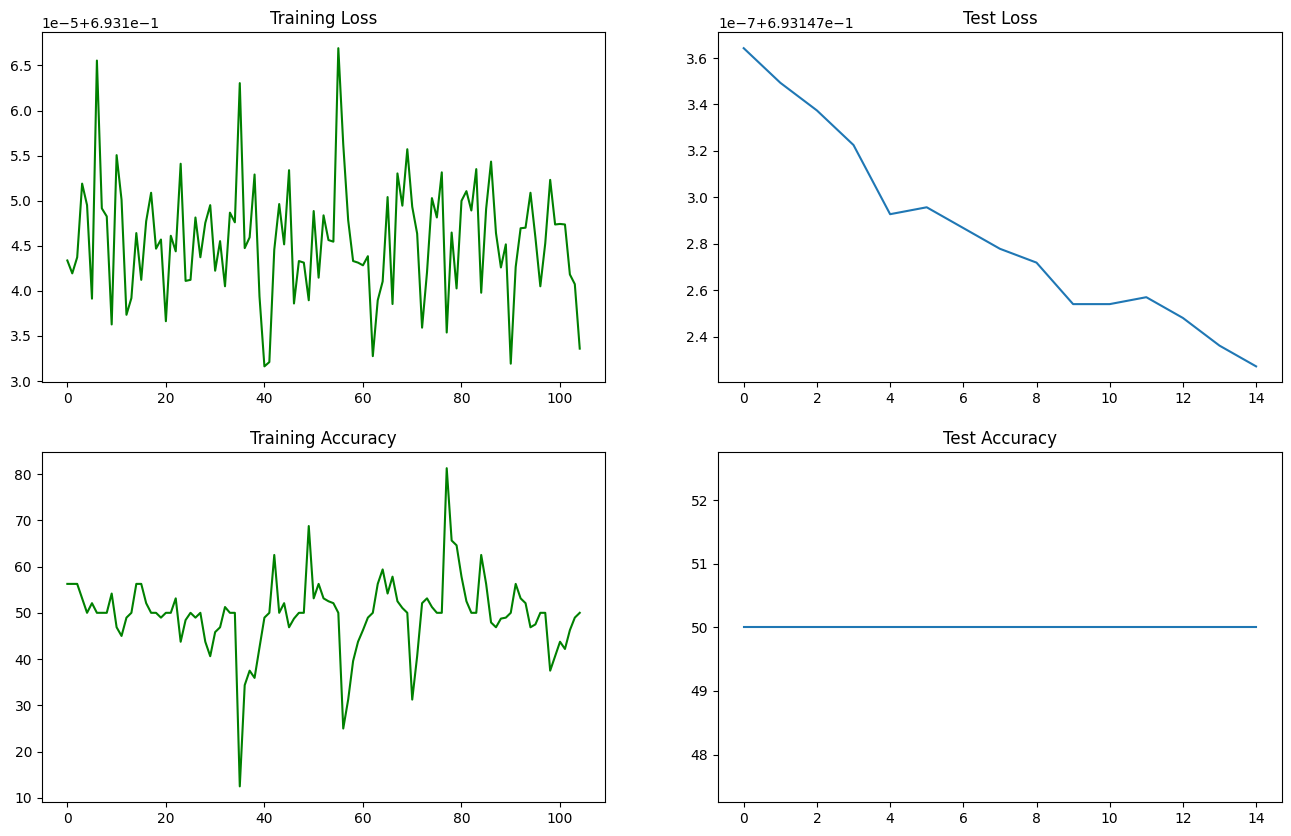

In [27]:
train_losses1 = [float(i.cpu().detach().numpy())for i in train_losses]
train_acc1 = [i for i in train_acc]
test_losses1 = [i for i in test_losses]
test_acc1 = [i for i in test_acc]

fig, axs = plt.subplots(2,2, figsize=(16,10))
axs[0,0].plot(train_losses1, color='green')
axs[0,0].set_title("Training Loss")
axs[1,0].plot(train_acc1, color='green')
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses1)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc1)
axs[1, 1].set_title("Test Accuracy")
